In [1]:
import argparse
import shutil
import json
import importlib
import os
import sys
import pickle
from sklearn.neighbors import NearestNeighbors

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from metrics import compute_classification_metrics, compute_regression_metrics

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

---

# Load Moos Datasets

In [4]:
def load_datasets(filename="dataset.pkl"):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data["datasets"], data["meta_variables"]

datasets, meta_vars = load_datasets('./data/Moons/dataset.pkl')

len(datasets), meta_vars.shape

(641, (641, 2))

### We have 641 domains. The first 50 domains will be used for training and the rest for testing.

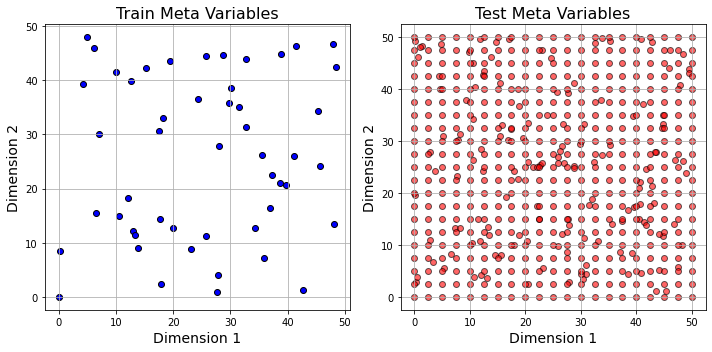

In [5]:
train_meta = meta_vars[:50]
test_meta = meta_vars[50:]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].scatter(train_meta[:, 0], train_meta[:, 1], color='blue', edgecolors='k')
axes[0].set_title('Train Meta Variables', fontsize=16)
axes[0].set_xlabel('Dimension 1', fontsize=14)
axes[0].set_ylabel('Dimension 2', fontsize=14)
axes[0].grid(True)

axes[1].scatter(test_meta[:, 0], test_meta[:, 1], color='red', alpha=0.6, edgecolors='k')
axes[1].set_title('Test Meta Variables', fontsize=16)
axes[1].set_xlabel('Dimension 1', fontsize=14)
axes[1].set_ylabel('Dimension 2', fontsize=14)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [6]:
def build_domains(train_idx, test_idx, datasets, meta_vars, device):
    domains = []
    test_domains = []
    for idx in train_idx:
        X_i, Y_i = datasets[idx]
        meta = meta_vars[idx]
        domains.append((torch.tensor([meta], dtype=torch.float32, device=device),
                        torch.tensor(X_i, dtype=torch.float32, device=device), torch.Tensor(Y_i).long().to(device)))

    for idx in test_idx:
        X_i, Y_i = datasets[idx]
        meta = meta_vars[idx]
        test_domains.append((torch.tensor([meta], dtype=torch.float32, device=device),
                             torch.tensor(X_i, dtype=torch.float32, device=device),
                             torch.Tensor(Y_i).long().to(device)))
    return domains, test_domains

meta_vars = meta_vars - meta_vars.min(axis=0)
meta_vars = meta_vars / meta_vars.max(axis=0)
        
train_idx = np.arange(50)
all_idx = np.arange(len(datasets))
test_idx = np.setdiff1d(all_idx, train_idx)

domains, test_domains = build_domains(train_idx, test_idx, datasets, meta_vars, device)

In [7]:
# Local Charts
n_neighbors = 5
neighbor_model = NearestNeighbors(n_neighbors=n_neighbors + 1, algorithm='ball_tree').fit(meta_vars[train_idx])
_, indices = neighbor_model.kneighbors(meta_vars[train_idx])
neighbors = {idx: indices[i] for i, idx in enumerate(train_idx)}

---

# Train Model

In [8]:
from utils import *

In [9]:
class NeuralLTO(nn.Module):
    def __init__(self, dim, meta_input_dim, n_mani=2, hidden=128):
        super().__init__()
        self.dim = dim
        self.n_mani = n_mani

        self.field_net = nn.Sequential(
            nn.Linear(meta_input_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, n_mani * dim * dim),
        )

        self.meta_embed = nn.Sequential(
            nn.Linear(meta_input_dim, n_mani, bias=False),
        )

    def forward(self, xy, xy0, e0):
        L_all = self.field_net(xy0).view(self.n_mani, self.dim, self.dim)
        diff = xy - xy0

        e_trans = e0
        for i in range(diff.shape[1]):
            Li = L_all[i]
            exp_Li = torch.matrix_exp(diff[:, i] * Li)
            e_trans = torch.matmul(e_trans, exp_Li.t())
        return e_trans

In [10]:
num_domains = len(domains)
meta_input_dim = meta_vars.shape[1]

transport_net = NeuralLTO(32, meta_input_dim).to(device)
predictive_model = predictive_model
domain_models = nn.ModuleList([predictive_model.to(device) for _ in range(num_domains)])
theta_list = nn.ParameterList([nn.Parameter(torch.cat([p.flatten() for p in m.parameters()])) for m in domain_models])
encoder = Encoder(param_dim=param_size, embed_dim=32).to(device)
decoder = Decoder(embed_dim=32, param_dim=param_size).to(device)

In [11]:
optimizer = torch.optim.Adam([
    {'params': theta_list.parameters(), 'lr': 1e-3, 'weight_decay': 1e-4},
    {'params': encoder.parameters(), 'lr': 1e-3, 'weight_decay': 1e-4},
    {'params': decoder.parameters(), 'lr': 1e-3, 'weight_decay': 1e-4},
    {'params': transport_net.parameters(), 'lr': 1e-3, 'weight_decay': 1e-4}
])

In [12]:
best_epoch_loss = np.inf

for epoch in range(200):
    epoch_loss = 0.0
    for batch_idx in np.array_split(train_idx, len(train_idx) // 5):
        optimizer.zero_grad()

        loss_1, loss_2, loss_recon, loss_embed, loss_consis = 0.0, 0.0, 0.0, 0.0, 0.0

        for idx in batch_idx:
            rs_i, X_i, Y_i = domains[idx] # descriptor, X, Y

            theta_i = theta_list[idx]
            e_i = encoder(theta_i.unsqueeze(0))
            theta_i_recon = decoder(e_i).squeeze(0)

            l_rec = F.mse_loss(theta_i_recon, theta_i)
            loss_recon += l_rec

            for neighbor_idx in neighbors[idx]:
                rs_neighbor, X_neighbor, Y_neighbor = domains[neighbor_idx]
                theta_neighbor = theta_list[neighbor_idx]
                e_neighbor = encoder(theta_neighbor.unsqueeze(0))

                e_neighbor_pred = transport_net(rs_neighbor, rs_i, e_i)
                theta_neighbor_pred = decoder(e_neighbor_pred).squeeze(0)

                l_j = F.nll_loss(forward_with_params(X_neighbor, theta_neighbor_pred, param_shapes), Y_neighbor)
                l_i = F.nll_loss(forward_with_params(X_i, theta_i, param_shapes), Y_i)

                loss_1 += l_i
                loss_2 += l_j

                l_embed = F.mse_loss(e_neighbor, e_neighbor_pred)
                loss_embed += l_embed

                l_consis = F.mse_loss(theta_neighbor, theta_neighbor_pred)
                loss_consis += l_consis

        total_loss = loss_1 + loss_2 + 100 * loss_recon + 10 * loss_embed + 100 * loss_consis
        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss
        
    if epoch_loss < best_epoch_loss:
        checkpoint = {
            "theta_list": theta_list.state_dict(),
            "encoder": encoder.state_dict(),
            "decoder": decoder.state_dict(),
            "transport_net": transport_net.state_dict(),
        }
        torch.save(checkpoint, 'checkpoint.pth')
        best_epoch_loss = epoch_loss
    
    if (epoch + 1) % 10 == 0:
        log_str = f"Epoch {epoch + 1}/{200}, Total Loss={epoch_loss.item():.4f}"
        print(log_str)
        
checkpoint = torch.load('checkpoint.pth')
transport_net.load_state_dict(checkpoint["transport_net"])
encoder.load_state_dict(checkpoint["encoder"])
decoder.load_state_dict(checkpoint["decoder"])
theta_list.load_state_dict(checkpoint["theta_list"])

Epoch 10/200, Total Loss=316.2539
Epoch 20/200, Total Loss=282.9156
Epoch 30/200, Total Loss=219.9352
Epoch 40/200, Total Loss=151.7207
Epoch 50/200, Total Loss=152.8978
Epoch 60/200, Total Loss=101.4607
Epoch 70/200, Total Loss=78.2886
Epoch 80/200, Total Loss=61.1268
Epoch 90/200, Total Loss=50.2324
Epoch 100/200, Total Loss=39.5218
Epoch 110/200, Total Loss=33.2760
Epoch 120/200, Total Loss=25.9175
Epoch 130/200, Total Loss=24.7533
Epoch 140/200, Total Loss=83.1364
Epoch 150/200, Total Loss=34.4243
Epoch 160/200, Total Loss=18.9188
Epoch 170/200, Total Loss=17.5405
Epoch 180/200, Total Loss=17.1971
Epoch 190/200, Total Loss=35.7391
Epoch 200/200, Total Loss=21.4859


<All keys matched successfully>

---

# Test Model

In [13]:
prediction, label = [], []

for idx, (rs_tensor, X_star, Y_star) in enumerate(test_domains):
    rs_tensor, X_star, Y_star = rs_tensor.to(device), X_star.to(device), Y_star.to(device)
    with torch.no_grad():
        meta_query = rs_tensor.cpu().numpy().reshape(1, -1)
        distances, indices = neighbor_model.kneighbors(meta_query)
        ref_idx = train_idx[indices[0][0]]

        rs0, e0 = domains[ref_idx][0], theta_list[ref_idx]

        E_star = transport_net(rs_tensor, rs0, encoder(e0).unsqueeze(0))
        theta_star = decoder(E_star).squeeze(0)
        pred = forward_with_params(X_star, theta_star, param_shapes)

        prediction.append(pred.detach().cpu().numpy())
        label.append(Y_star.cpu().numpy())
        
metrics = compute_classification_metrics(label, prediction)
score_log = f"{metrics}"
print(score_log)

{'acc': 0.9718629441624366, 'err': 0.02813705583756343, 'f1': 0.9718601823122539, 'auc': None}


### We have the Error score on the test sets of 2.8\%

---

# Model Manifold

## Build the dense mesh

In [14]:
x = np.linspace(0, 50, 100)
y = np.linspace(0, 50, 100)
xx, yy = np.meshgrid(x, y)
mesh_points = np.stack([xx.ravel(), yy.ravel()], axis=1)

meta_normalized = mesh_points / 50

meta_tensor = torch.tensor(meta_normalized, dtype=torch.float32).to(device)

## Estimate the predictive models on the dense mesh

In [15]:
theta_all, E_all = [], []

with torch.no_grad():
    for i in range(meta_tensor.shape[0]):
        rs_tensor = meta_tensor[i].unsqueeze(0)

        distances, indices = neighbor_model.kneighbors(rs_tensor.cpu().numpy())
        ref_idx = train_idx[indices[0][0]]
        rs0, e0 = domains[ref_idx][0],  theta_list[ref_idx]

        E_star = transport_net(rs_tensor, rs0, encoder(e0).unsqueeze(0))
        theta_star = decoder(E_star).squeeze(0)
        
        E_all.append(E_star.squeeze(0).cpu().numpy())
        theta_all.append(theta_star.cpu().numpy())

theta_all = np.stack(theta_all, axis=0)
E_all = np.stack(E_all, axis=0)
theta_all.shape, E_all.shape

((10000, 2802), (10000, 32))

## PCA

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
theta_3d = pca.fit_transform(theta_all)
theta_3d.shape

(10000, 1)

## Vis the model manifold

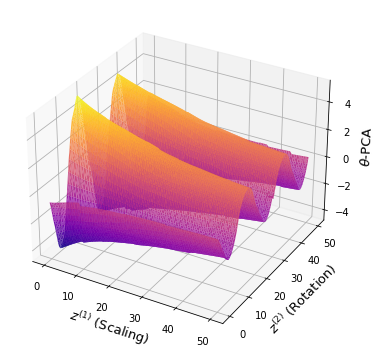

In [17]:
from mpl_toolkits.mplot3d import Axes3D

x = mesh_points[:, 0]
y = mesh_points[:, 1]
z = theta_3d[:, 0]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(mesh_points[:, 0], mesh_points[:, 1], theta_3d[:, 0],
                cmap='plasma', edgecolor='none', alpha=0.95)

ax.set_xlabel(r"$z^{(1)}$ (Scaling)", fontsize=13)
ax.set_ylabel(r"$z^{(2)}$ (Rotation)", fontsize=13)
ax.set_zlabel(r'$\theta$-PCA', fontsize=13)
plt.tight_layout()
plt.show()